# Show how double transport affect rate performance - plot solutions, produce Fig. 5-8

### $ D_{\text{e},\text{EC}}^0 = 0, \, 1 \times 10^{-11} \ \text{m}^2/\text{s} $

In [37]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2 
import pybamm;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; import sys  
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing;import pandas as pd;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/")
Target  = 'Rate_Performance/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Save_Fig = True

In [39]:
# define parameter of double and single 
Para_dict_Same = {
   "Mesh list":[ [10,5,10,100,20], ],    # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   "Contact resistance [Ohm]":[6e-3],
   "Initial Neg SOC":[0.8841301667966484,],
   "Initial Pos SOC":[0.23552755074598045,],}
Para_dict_DD_ONLY = {
   "Model option":[{
      "SEI": "constant",
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0,1e-11], # 
}
Para_dict_SD_ONLY = {
   "Model option":[{
      "SEI": "constant",
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "single no consume wo refill",
      "electrolyte conductivity": "full"  ,
      "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0,], #  
   #"Measured dLJP_dce":["dLJP_1_Specie_dc_e_np",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))

Path_pack = [BasicPath,Target,]

2 1


In [40]:
book_name_xlsx = 'Test.xlsx';sheet_name_xlsx = 'Results';
Path_Exp_Crate =  os.path.expanduser(
    "~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Ruihe_newLGM50_Crate/")
Path_pack = [BasicPath,Target,Path_Exp_Crate,book_name_xlsx,sheet_name_xlsx,];

In [41]:
Rate_Dis_All = [1,1.2,1.4,1.6,1.8,1.81,1.82,1.83] #  ,1.84,1.85,1.86
print(Rate_Dis_All,len(Rate_Dis_All))

[1, 1.2, 1.4, 1.6, 1.8, 1.81, 1.82, 1.83] 8


### solution is already obtained via another script: wip/Rio_Code/P3_R14/Rate_Performance_Get_Sol.ipynb, so this is just to reload and plot

In [42]:
# reload one C-rate
def Reload_RatePer(BasicPath , Target,str_pickle,para,Rate_Dis_All):
    Case_Dict = {}
    import pickle
    # para = Para_DD[i] or Para_SD[i]
    D_e_EC_cross = para["Lithium ion EC cross diffusivity [m2.s-1]"]
    # str_pickle = f"Double_D_e_EC_cross={D_e_EC_cross}"
    Sol_All =[]; Cap_Dis_All = [];  Trise_All = []; 
    Time_dis_All =[];Vol_dis_All =[];
    for Rate_Dis in Rate_Dis_All:
        file_path = BasicPath + Target + f'{str_pickle}_Rate={Rate_Dis}C.pkl'
        with open(file_path, 'rb') as file:
            sol = pickle.load(file)
        # post-process
        step_i = sol.cycles[0].steps[1]
        cap = (
            step_i["Discharge capacity [A.h]"].entries[-1]
            -step_i["Discharge capacity [A.h]"].entries[0])
        Trise = (
            step_i["Volume-averaged cell temperature [C]"].entries[-1]
            -step_i["Volume-averaged cell temperature [C]"].entries[0])
        t_dis =( 
            step_i["Time [h]"].entries - step_i["Time [h]"].entries[0] 
            ) 
        vol_dis = step_i["Terminal voltage [V]"].entries 
        Sol_All.append(sol)
        Cap_Dis_All.append(cap)
        Trise_All.append(Trise)
        Time_dis_All.append(t_dis)
        Vol_dis_All.append(vol_dis)
    Case_Dict ['Cap_Dis_All'] = Cap_Dis_All
    Case_Dict ['Sol_All']  = Sol_All
    Case_Dict ['Rate_Dis_All']  = Rate_Dis_All
    Case_Dict ['Trise_All']  = Trise_All
    Case_Dict ['Time_dis_All']  = Time_dis_All
    Case_Dict ['Vol_dis_All']  = Vol_dis_All
    return Case_Dict
D_e_EC_cross = Para_DD[1]["Lithium ion EC cross diffusivity [m2.s-1]"]
DD_HDx_Crate = Reload_RatePer(
    BasicPath , Target, f"Double_D_e_EC_cross={D_e_EC_cross}",
    Para_DD[1],Rate_Dis_All)
D_e_EC_cross = Para_DD[0]["Lithium ion EC cross diffusivity [m2.s-1]"]
DD_LDx_Crate = Reload_RatePer(
    BasicPath , Target, f"Double_D_e_EC_cross={D_e_EC_cross}",
    Para_DD[0],Rate_Dis_All)
SD_Crate     = Reload_RatePer(BasicPath , Target,"Single",Para_SD[0],Rate_Dis_All)
# need 18 min to reload - almost 100 GB! - Vmmen - 46 GB

In [43]:
# cyc based 
def Get_Vol_Component(DD_HDx_Crate):
    DD_HDx_Crate['Cyc Mean eta_c_e'] = []
    DD_HDx_Crate['Cyc Mean eta_c_EC'] = []
    DD_HDx_Crate['Cyc Mean eta_others'] = []
    DD_HDx_Crate['Cyc Mean eta_tot'] = []
    DD_HDx_Crate['Cyc Last eta_c_e'] = []
    DD_HDx_Crate['Cyc Last eta_c_EC'] = []
    DD_HDx_Crate['Cyc Last eta_others'] = []
    DD_HDx_Crate['Cyc Last eta_tot'] = []
    DD_HDx_Crate['Cyc Mean eta_c_e %'] = []
    DD_HDx_Crate['Cyc Mean eta_c_EC %'] = []
    DD_HDx_Crate['Cyc Mean eta_others %'] = []
    for sol in DD_HDx_Crate['Sol_All']:
        step_CD = sol.cycles[0].steps[1]
        ocv = step_CD["X-averaged battery open circuit voltage [V]"].entries
        eta_c_e = -step_CD[
            "X-averaged battery concentration overpotential [V]"].entries
        eta_c_EC = -step_CD[
            "X-averaged EC concentration overpotential [V]"].entries
        V = step_CD["Terminal voltage [V]"].entries
        eta_others = ocv - eta_c_e - eta_c_EC - V
        eta_tot = ocv - V
        mean_eta_c_e = np.mean(eta_c_e)
        mean_eta_c_EC = np.mean(eta_c_EC)
        mean_eta_others = np.mean(eta_others)
        mean_eta_c_tot = np.mean(eta_tot)
        DD_HDx_Crate['Cyc Mean eta_c_e'].append(np.mean(eta_c_e))
        DD_HDx_Crate['Cyc Mean eta_c_EC'].append(np.mean(eta_c_EC))
        DD_HDx_Crate['Cyc Mean eta_others'].append(np.mean(eta_others))
        DD_HDx_Crate['Cyc Mean eta_tot'].append(np.mean(eta_tot))
        DD_HDx_Crate['Cyc Last eta_c_e'].append(eta_c_e[-1])
        DD_HDx_Crate['Cyc Last eta_c_EC'].append(eta_c_EC[-1])
        DD_HDx_Crate['Cyc Last eta_others'].append(eta_others[-1])
        DD_HDx_Crate['Cyc Last eta_tot'].append(eta_tot[-1])
        DD_HDx_Crate['Cyc Mean eta_c_e %'].append(
            mean_eta_c_e/mean_eta_c_tot*100)
        DD_HDx_Crate['Cyc Mean eta_c_EC %'].append(
            mean_eta_c_EC/mean_eta_c_tot*100)
        DD_HDx_Crate['Cyc Mean eta_others %'].append(
            mean_eta_others/mean_eta_c_tot*100)
    return DD_HDx_Crate
DD_HDx_Crate = Get_Vol_Component(DD_HDx_Crate)
DD_LDx_Crate = Get_Vol_Component(DD_LDx_Crate)
SD_Crate     = Get_Vol_Component(SD_Crate)

1657.3002637595498 2.6755753561901123
1699.8041306669845 2.5000099999999987


(1.82, 1.86)

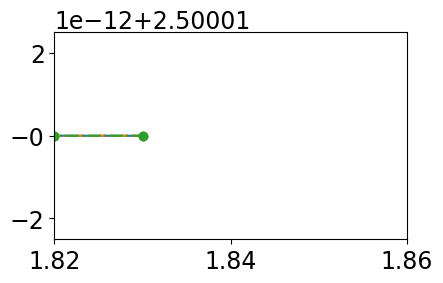

In [44]:
# Find out that the main reason for the low capacity is that the model stops at 2.8V!
i=-1
step_i = DD_HDx_Crate['Sol_All'][i].cycles[0].steps[1]
print(step_i["Time [s]"].entries[-2],step_i["Terminal voltage [V]"].entries[-2])
print(step_i["Time [s]"].entries[-1],step_i["Terminal voltage [V]"].entries[-1])
# plot voltage:
Vol_HD_End = []; Vol_LD_End = []; Vol_SD_End = []; 
for i in range(len(Rate_Dis_All)):
    Vol_HD_End.append(
        DD_HDx_Crate['Sol_All'][i].cycles[0].steps[1][
            "Terminal voltage [V]"].entries[-1])
    Vol_LD_End.append(
        DD_LDx_Crate['Sol_All'][i].cycles[0].steps[1][
            "Terminal voltage [V]"].entries[-1])
    Vol_SD_End.append(
        SD_Crate['Sol_All'][i].cycles[0].steps[1][
            "Terminal voltage [V]"].entries[-1])
fig, axs = plt.subplots( figsize=(12/2.53,8/2.54),tight_layout=True)
axs.plot(Rate_Dis_All,Vol_HD_End,"-",marker = 'o',label="HD")
axs.plot(Rate_Dis_All,Vol_LD_End,"--",marker = 'o',label="LD")
axs.plot(Rate_Dis_All,Vol_SD_End,"-.",marker = 'o',label="SD")
axs.set_xlim([1.82,1.86])
# the highest C rate is only 1.83C!!!

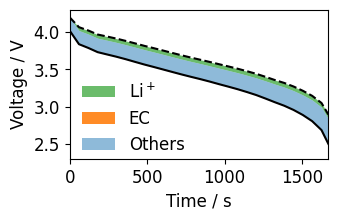

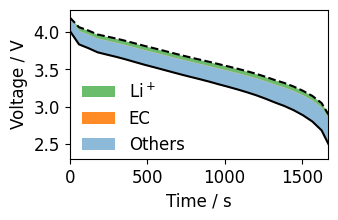

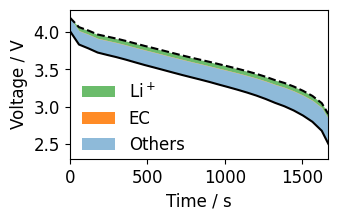

In [45]:
# Fig. 3 - only overpotential, and three components:
def Plot_Voldecom_All(DD_HDx_Crate,Crate_index,Save_Fig):
    #Crate_index = -1
    Colors_a = [
        [31/255, 119/255, 180/255, 0.5], # like blue
        [44/255, 160/255, 44/255,  0.7], # like green  
        [214/255, 39/255, 40/255,  0.7], # like red
        [255/255, 127/255, 14/255, 0.9],]# like orange 
    Colors_b = [
        [31/255, 119/255, 180/255, 0.0], # like blue
        [44/255, 160/255, 44/255,  0.0], # like green  
        [214/255, 39/255, 40/255,  0.0], # like red
        [255/255, 127/255, 14/255, 0.0],]# like orange 
    sol_dd_HDx = DD_HDx_Crate['Sol_All'][Crate_index]
    step_CD = sol_dd_HDx.cycles[0].steps[1]
    time = step_CD["Time [s]"].entries - step_CD["Time [s]"].entries[0] # 
    zeros = 0*np.ones_like(time)
    ocv = step_CD["X-averaged battery open circuit voltage [V]"].entries
    Total_overpotential = ocv - step_CD["Terminal voltage [V]"].entries;
    eta_c_e = -step_CD["X-averaged battery concentration overpotential [V]"].entries
    eta_c_EC = -step_CD["X-averaged EC concentration overpotential [V]"].entries
    V = step_CD["Terminal voltage [V]"].entries
    eta_others = ocv - eta_c_e - eta_c_EC - V
    eta_tot = ocv - V

    fs = 12; font = {'family' : 'DejaVu Sans','size'   : fs}
    mpl.rc('font', **font)
    fig, ax = plt.subplots(figsize=(9/2.54,6/2.54),tight_layout=True)
    ax.plot(time, ocv, "k--", ) # label="Open-circuit voltage"
    ax.fill_between(time, ocv-eta_c_e, ocv, color=Colors_a[1], edgecolor=Colors_b[1], label=r"Li$^+$")
    #ax.plot(time, ocv-eta_c_e,  color=Colors_a[1], label=r"Li$^+$")
    ax.fill_between(time, ocv-eta_c_e-eta_c_EC, ocv-eta_c_e, color=Colors_a[3], edgecolor=Colors_b[3], label="EC")
    #ax.plot(time, ocv-eta_c_e-eta_c_EC, color=Colors_a[3],  label="EC")
    ax.fill_between(time, V, ocv-eta_c_e-eta_c_EC,  color=Colors_a[0],edgecolor=Colors_b[0],  label="Others")

    ax.plot(time, V, "k-", ) # label="Terminal voltage"

    leg = ax.legend(loc="lower left", bbox_to_anchor=(-0.01, -0.07),frameon=False)
    ax.set_xlim([time[0], time[-1]])
    ax.set_xlabel("Time / s")
    ax.set_ylabel("Voltage / V")
    #ax.set_ylabel(r"$\vec \nabla \cdot \vec N_\mathrm{diff}$") 
    ax.set_ylim([2.3,4.3])
    #plt.show() # it is this thing that make the save not good!!!
    if Save_Fig == True:
        plt.savefig(BasicPath + Target
            +f"{Rate_Dis_All[Crate_index]}C discharge voltage decomposition.png", 
            dpi=1000)
        plt.savefig(BasicPath + Target + 
            f'{Rate_Dis_All[Crate_index]}C discharge voltage decomposition.svg') 
    # plt.close()
""" for i in range(len(Rate_Dis_All)):
    Plot_Voldecom_All(SD_Crate,i,Save_Fig)
    Plot_Voldecom_All(DD_LDx_Crate,i,Save_Fig)
    Plot_Voldecom_All(DD_HDx_Crate,i,  Save_Fig) """
# Rate_Dis_All = [1,1.2,1.4,1.6,1.8,1.85,1.88,1.9]
i = -1
Plot_Voldecom_All(SD_Crate,i,Save_Fig)
Plot_Voldecom_All(DD_LDx_Crate,i,Save_Fig)
Plot_Voldecom_All(DD_HDx_Crate,i,  Save_Fig)

In [75]:
# plot EC concentraton change 
def Plot_Loc_Var_sol_10( 
        SD_Crate,Crate_index, str, x_loc_all, key_all,titles,YlimAll, 
        cycle, step,colormap,fs,Save_Fig): # for initial solution object
    font = {'family' : 'DejaVu Sans','size'   : fs}
    mpl.rc('font', **font)

    sol = SD_Crate['Sol_All'][Crate_index]

    #[key_Li,key_EC] = key_all
    Num_subplot = len(key_all[0]); # must have 2+ keys
    fig, axs = plt.subplots(2,Num_subplot, figsize=(30/2.53,12/2.54),tight_layout=True)

    for m in range(0,len(key_all)):
        keys = key_all[m]
        Ylim = YlimAll[m]
        for n in range(0,Num_subplot):
            x_loc=x_loc_all[n]; 
            key=keys[n]; 
            temp_L_Num= len(sol.cycles[cycle].steps[step][key].entries[0,:] )
            #print(f"Total line number is: {temp_L_Num}")
            if temp_L_Num > 26:
                xx = np.arange(0,temp_L_Num,int(np.rint(temp_L_Num/50)));
            else:
                xx = np.arange(0,temp_L_Num,1);
            xx = xx.tolist()
            if not xx[-1]==temp_L_Num-1:
                xx.append(temp_L_Num-1)
            cmap_i = mpl.cm.get_cmap(colormap, len(xx)) 
            for index_j,j in zip(  range(0,len(xx)), xx):
                len_1 = len(sol.cycles[cycle].steps[step][x_loc].entries[:,0])
                len_2 = len(sol.cycles[cycle].steps[step][key].entries[:,j])
                if len_1>len_2:
                    axs[m,n].plot(
                        sol.cycles[cycle].steps[step][x_loc].entries[0:len_2,0]*1e6, 
                        sol.cycles[cycle].steps[step][key].entries[:,j], '-',
                        color=cmap_i(index_j),)
                elif len_1<len_2:
                    axs[m,n].plot(
                        sol.cycles[cycle].steps[step][x_loc].entries[:,0]*1e6, 
                        sol.cycles[cycle].steps[step][key].entries[0:len_1,j], '-',
                        color=cmap_i(index_j),)
                else:    
                    axs[m,n].plot(
                        sol.cycles[cycle].steps[step][x_loc].entries[:,0]*1e6, 
                        sol.cycles[cycle].steps[step][key].entries[:,j], '-',
                        color=cmap_i(index_j),)
            Y_0p = np.arange(-1e8,1e8,5e7)
            axs[m,n].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
            axs[m,n].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
            axs[m,n].set_ylim(Ylim[n])
            axs[1,n].set_xlabel(r"x / $\mu$m",   fontdict={'family':'DejaVu Sans','size':fs})
            axs[m,n].ticklabel_format( 
                axis='y', style='sci',
                scilimits=[-1e-6,1e-6], useOffset=None, 
                useLocale=None, useMathText=True) # """
            axs[m,n].tick_params(
                labelcolor='k', labelsize=fs, width=1) ; 
            labels = axs[m,n].get_xticklabels() + axs[m,n].get_yticklabels(); 
            [label.set_fontname('DejaVu Sans') for label in labels]
            axs[0,n].set_title(titles[n] ,   fontdict={'family':'DejaVu Sans','size':fs+1})
    axs[0,0].set_ylabel(r"c / mol/m$^{3}$")
    axs[1,0].set_ylabel(r"c / mol/m$^{3}$")
    axs[0,1].set_ylabel(r"$\partial(\epsilon c)$/$\partial$(t) / mol/m$^{3}$/s")
    axs[1,1].set_ylabel(r"$\partial(\epsilon c)$/$\partial$(t) / mol/m$^{3}$/s")
    if Save_Fig == True:
        plt.savefig(BasicPath + Target
            +f"{str}_{Rate_Dis_All[Crate_index]}C - c(Li+) and flux.png", 
            dpi=1000)
        plt.savefig(BasicPath + Target + 
            f'{str}_{Rate_Dis_All[Crate_index]}C - c(Li+) and flux.svg') 
    return 

/tmp/ipykernel_7015/1930442290.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_i = mpl.cm.get_cmap(colormap, len(xx))


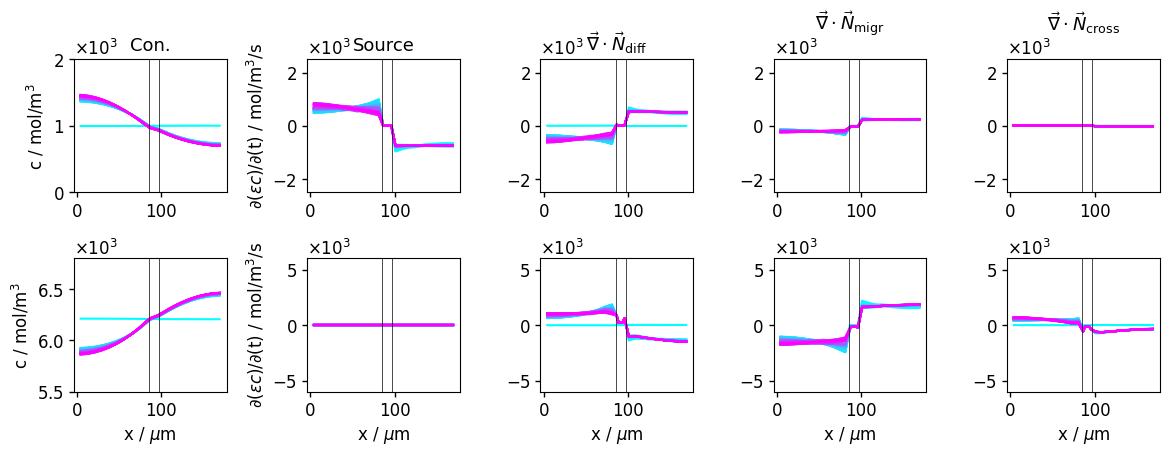

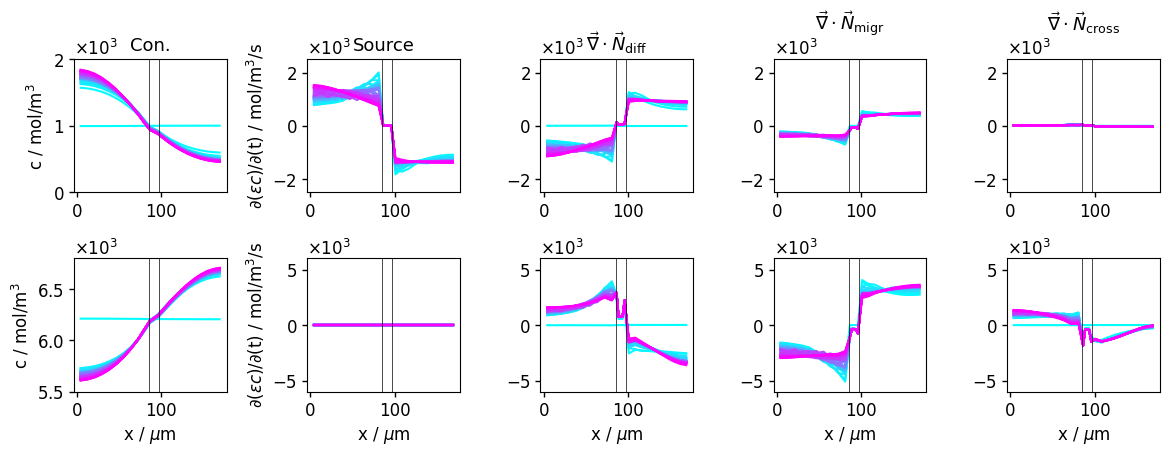

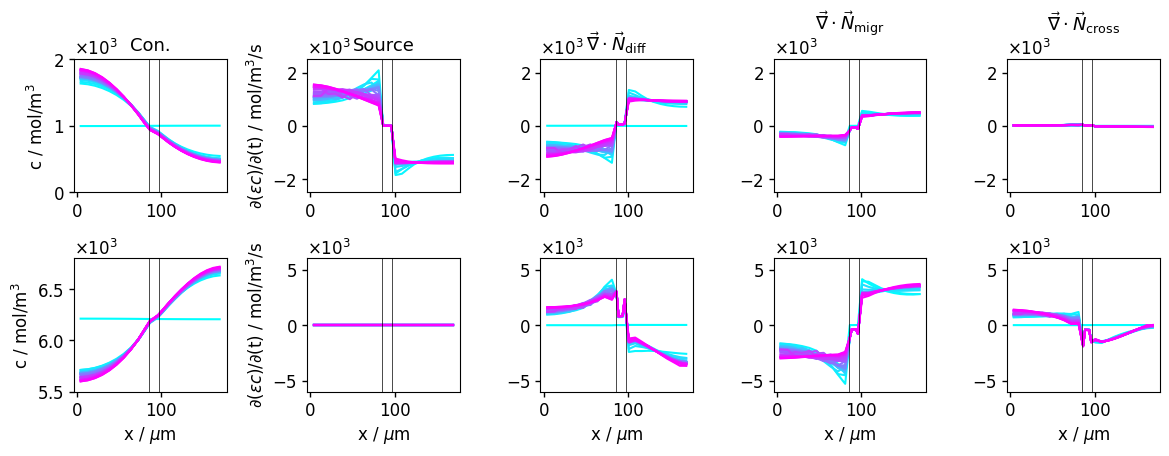

In [80]:
# Plot concentration flux and source - 4.5C high Dx
x_loc_all = ["x [m]"]*5
key_Li = [
    "Electrolyte concentration [mol.m-3]",
    "Li+ source term [mol.m-3.s-1]",
    # "y_e",
    "Minus div Li+ flux by diffusion [mol.m-3.s-1]",
    "Minus div Li+ flux by migration [mol.m-3.s-1]",
    "Minus div Li+ flux by solvent [mol.m-3.s-1]",
]
key_EC = [
    "EC concentration [mol.m-3]",
    "EC source term (SEI) [mol.m-3.s-1]",
    # "y_EC",
    "Minus div EC flux by diffusion [mol.m-3.s-1]",
    "Minus div EC flux by migration [mol.m-3.s-1]",
    "Minus div EC flux by Li+ [mol.m-3.s-1]",
]
titles = [
    "Con.",#r"Li$^+$",
    "Source",
    #"y",
    r"$\vec \nabla \cdot \vec N_\mathrm{diff}$",
    r"$\vec \nabla \cdot \vec N_\mathrm{migr}$",
    r"$\vec \nabla \cdot \vec N_\mathrm{cross}$"
]
key_all = [key_Li,key_EC];
YlimAll = [
    [[0e2,2e3],[-2.5e3,2.5e3],[-2.5e3,2.5e3],[-2.5e3,2.5e3],[-2.5e3,2.5e3]],
    [[5.5e3,6.8e3],[-6e3,6e3],[-6e3,6e3],[-6e3,6e3],[-6e3,6e3]]
]
Save_Fig = True
for Crate_index in [0,4,-1]:         # Rate_Dis_All = [1,1.2,1.4,1.6,1.8,1.81,1.82,1.83]
    Plot_Loc_Var_sol_10( 
        DD_HDx_Crate,Crate_index,"Double High Dx",x_loc_all, 
        key_all,titles, YlimAll, 0, -1,"cool",12,Save_Fig)
    """ Plot_Loc_Var_sol_10( 
        DD_LDx_Crate,Crate_index,"Double Low Dx",x_loc_all, 
        key_all,titles, YlimAll, 0, -1,"cool",12,Save_Fig)
    Plot_Loc_Var_sol_10( 
        SD_Crate,Crate_index,"Single",x_loc_all, 
        key_all,titles, YlimAll, 0, -1,"cool",12,Save_Fig)"""

In [48]:
Crate_index = 0
SD_Crate['Sol_All'][Crate_index].cycles[0].steps[1][
    "X-averaged battery EC concentration overpotential [V]"].entries

array([0., 0., 0., ..., 0., 0., 0.])

Time selected is for 1C is 3285.999999999999 and 3285.9999999999995,3286.0 s
Time selected is for 1.8C is 1702.5999999999992 and 1702.5999999999995,1702.5999999999995 s
Time selected is for 1.83C is 1625.9618601538978 and 1625.9618601538975,1625.9618601538978 s


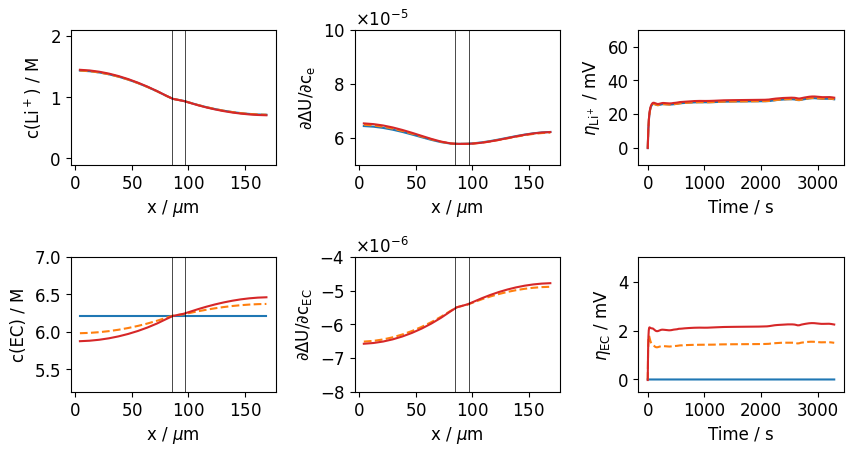

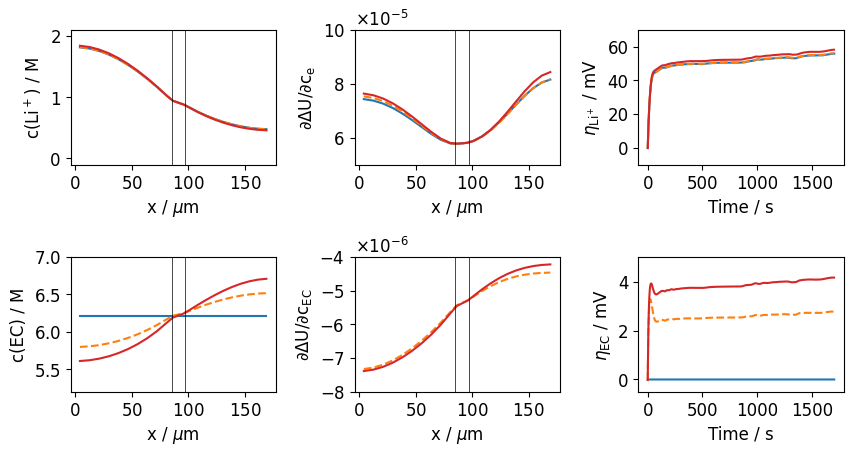

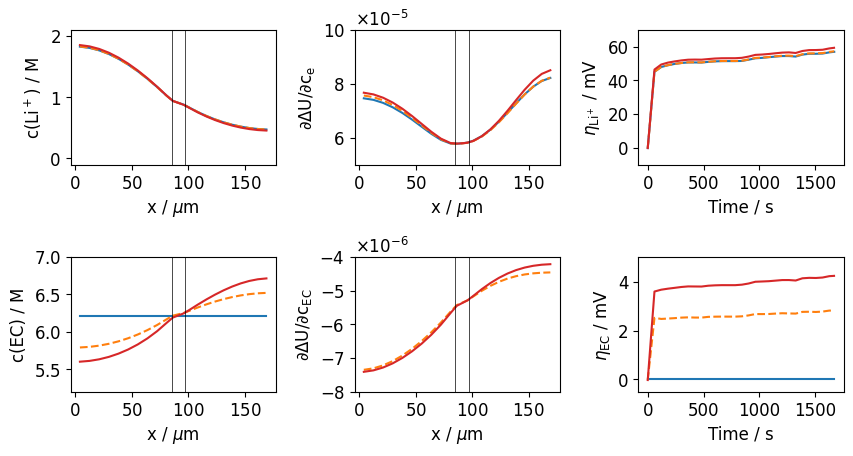

In [81]:
# Fig. 4 Concentration, LJP and overpotential 
def FindClose(time_DD,t_select): # Input must be a list
    for i in range(0,len(time_DD)):
        if abs(time_DD[i] - t_select)<1e-3:
            break
    return i
fs = 12
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
Str=[ 'DFN',   'Double trans' ]; # Str_model =[ 'Model_DFN',   'Model_DD' ]
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
Labels = ["Single",r"Double-Low $D_\times$",r"Double-High $D_\times$"]
LS = ['-','--','-',];MS=['none','none','h']; ms = 8
Str=[ 'DFN',  'Double' ]
def Plot_Eta_c(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Ylim,Crate_index,Save_Fig):
    fig, axs = plt.subplots(2,3, figsize=(22/2.53,12/2.54),tight_layout=True) #,
    step_sd = SD_Crate['Sol_All'][Crate_index].cycles[0].steps[1]
    step_DD_LDx = DD_LDx_Crate['Sol_All'][Crate_index].cycles[0].steps[1]
    step_DD_HDx = DD_HDx_Crate['Sol_All'][Crate_index].cycles[0].steps[1]
    Steps = [step_sd,step_DD_LDx,step_DD_HDx] 
    Labels = [r"Single",r"Double-Low $\mathit{D}_\times$",r"Double-High $\mathit{D}_\times$"]
    for k,step in enumerate(Steps):
        axs[0,2].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            -step["X-averaged battery concentration overpotential [V]"].entries*1e3,
            color=Colors[k],linestyle=LS[k],label=Labels[k]) 
        axs[1,2].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            -step["X-averaged battery EC concentration overpotential [V]"].entries*1e3,
            color=Colors[k],linestyle=LS[k],label=Labels[k]) 
    axs[0,2].set_ylabel("$\eta_{\mathrm{Li}^+}$ / mV",fontsize=fs)
    #"$\partial\Delta$U/$\partial$c$_\mathrm{EC}$"
    axs[1,2].set_ylabel("$\eta_{\mathrm{EC}}$ / mV",fontsize=fs)
    axs[1,2].set_xlabel("Time / s",fontsize=fs)
    axs[0,2].set_xlabel("Time / s",fontsize=fs)
    #fig.suptitle(f"EC and Li+ overpotential - {Rate_Dis_All[Crate_index]}C Discharge", fontsize=fs+1)
    var_elely = [
        "Electrolyte concentration [mol.m-3]",
        "dLJP_dce",
        "EC concentration [mol.m-3]",
        "dLJP_dcEC",] 
    Title_elely = [
        "c(Li+) [M]",
        "dLJP_dce",
        "c(EC) [M]",
        "dLJP_dcEC",]

    time_Single_High = (step_sd['Time [s]'].entries-step_sd['Time [s]'].entries[0]).tolist()
    time_Double_High = (step_DD_HDx['Time [s]'].entries-step_DD_HDx['Time [s]'].entries[0]).tolist()
    time_Double_Low  = (step_DD_LDx['Time [s]'].entries-step_DD_LDx['Time [s]'].entries[0]).tolist()

    t_select = min(time_Single_High[-2],time_Double_High[-2],time_Double_Low[-2])
    i_Single_High = FindClose(time_Single_High,t_select)
    i_Double_High = FindClose(time_Double_High,t_select)

    i_Double_Low = FindClose(time_Double_Low,t_select)

    print(f'Time selected is for {Rate_Dis_All[Crate_index]}C is {time_Single_High[i_Single_High]} and {time_Double_High[i_Double_High]},{time_Double_Low[i_Double_Low]} s')
    Y_0p = np.arange(-1,100,10)
    Index_MN = [ [0,0],[0,1],[1,0],[1,1]     ]
    for i in range(4):
        m,n = Index_MN[i]
        x_Single_High =   step_sd[x_loc[i]].entries[:,0]
        y_Single_High =   step_sd[var_elely[i]].entries[:,i_Single_High]

        x_Double_High =   step_DD_HDx[x_loc[i]].entries[:,0]
        y_Double_High =   step_DD_HDx[var_elely[i]].entries[:,i_Double_High]
        x_Double_Low  =   step_DD_LDx[x_loc[i]].entries[:,0]
        y_Double_Low  =   step_DD_LDx[var_elely[i]].entries[:,i_Double_Low]
        if var_elely[i].__contains__("[mol.m-3]"): 
            axs[m,n].plot(x_Single_High*1e6, y_Single_High/1e3, color=Colors[0],linestyle=LS[0],label=r"Single") 
            axs[m,n].plot(x_Double_Low*1e6, y_Double_Low/1e3, color=Colors[1],linestyle=LS[1],label=r"Double-Low D$_\times$") 
            axs[m,n].plot(x_Double_High*1e6, y_Double_High/1e3, color=Colors[2],linestyle=LS[2],label=r"Double-High D$_\times$") 
            axs[m,n].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
            axs[m,n].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
        else:
            if var_elely[i] == "dLJP_dcEC": 
                pass
            else:
                axs[m,n].plot(x_Single_High*1e6, y_Single_High, color=Colors[0],linestyle=LS[0],label=r"Single") 
            axs[m,n].plot(x_Double_Low*1e6, y_Double_Low, color=Colors[1],linestyle=LS[1],label=r"Double-Low $D_\times$") 
            axs[m,n].plot(x_Double_High*1e6, y_Double_High, color=Colors[2],linestyle=LS[2],label=r"Double-High $D_\times$") 
            axs[m,n].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
            axs[m,n].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)

        axs[m,n].set_xlabel(r"x / $\mu$m",   fontdict={'family':'DejaVu Sans','size':fs})
        #axs[m,n].set_title(Title_elely[i]) 
        axs[m,n].ticklabel_format( 
            axis='x', style='sci',
            scilimits=[-1e2,1e2], useOffset=None, 
            useLocale=None, useMathText=True)
        axs[m,n].ticklabel_format( 
            axis='y', style='sci',
            scilimits=[-1e-2,1e-2], useOffset=None, 
            useLocale=None, useMathText=True)
    axs[0,0].set_ylabel("c(Li$^+$) / M");
    axs[1,0].set_ylabel("c(EC) / M")
    axs[0,1].set_ylabel("$\partial\Delta$U/$\partial$c$_\mathrm{e}$");  
    # axs[0,1].set_yscale("log")
    axs[1,1].set_ylabel("$\partial\Delta$U/$\partial$c$_\mathrm{EC}$")

    axs[0,0].set_ylim(Ylim[0])
    axs[0,1].set_ylim(Ylim[1])
    axs[1,0].set_ylim(Ylim[2])
    axs[1,1].set_ylim(Ylim[3])
    axs[0,2].set_ylim(Ylim[4])
    axs[1,2].set_ylim(Ylim[5])
    fig.subplots_adjust(wspace=0, hspace=0)
    """ axs[1,2].legend(prop={'family':'DejaVu Sans','size':fs-0.5},
    loc='upper right',ncol=1,  bbox_to_anchor=(0.92, 0.7),
    frameon=False,markerscale=0.5,borderpad=0.0,
    handlelength=1.4,columnspacing=1) """
    if Save_Fig == True:
        plt.savefig(BasicPath + Target
                +f"Fig_4_{Rate_Dis_All[Crate_index]}C Overpotential and concentration.png", dpi=1000)
        plt.savefig(BasicPath + Target + 
                f"Fig_4_{Rate_Dis_All[Crate_index]}C Overpotential and concentration.svg") 

fs = 12;font = {'family' : 'DejaVu Sans','size': fs}
mpl.rc('font', **font)
LS = ['-','--','-',]; 

Ylim = [[-0.1,2.1],[0.5e-4,1.0e-4],[5.2,7],[-0.8e-5,-0.4e-5],[-10,70],[-0.5,5]]
for i in [0,4,-1]:   
    Plot_Eta_c(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Ylim,Crate_index=i,Save_Fig=True)


In [50]:
step = DD_HDx_Crate['Sol_All'][-1].cycles[0].steps[1]
step["dLJP_dcEC"].entries[:,-1]

array([-7.41537974e-06, -7.37196840e-06, -7.28657821e-06, -7.16170458e-06,
       -7.00023924e-06, -6.80458064e-06, -6.57570606e-06, -6.31237947e-06,
       -6.01084317e-06, -5.66559172e-06, -5.45258563e-06, -5.41183322e-06,
       -5.37083799e-06, -5.32960882e-06, -5.28815641e-06, -5.15731925e-06,
       -4.95498411e-06, -4.77318672e-06, -4.61585173e-06, -4.48544479e-06,
       -4.38259323e-06, -4.30606666e-06, -4.25317011e-06, -4.22049945e-06,
       -4.20531463e-06])

/tmp/ipykernel_7015/1227104938.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = mpl.cm.get_cmap("copper", len(Rate_Dis_All))


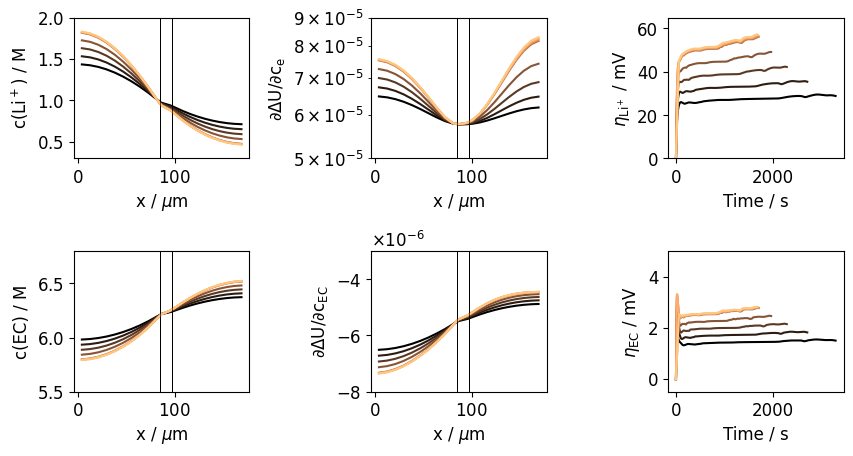

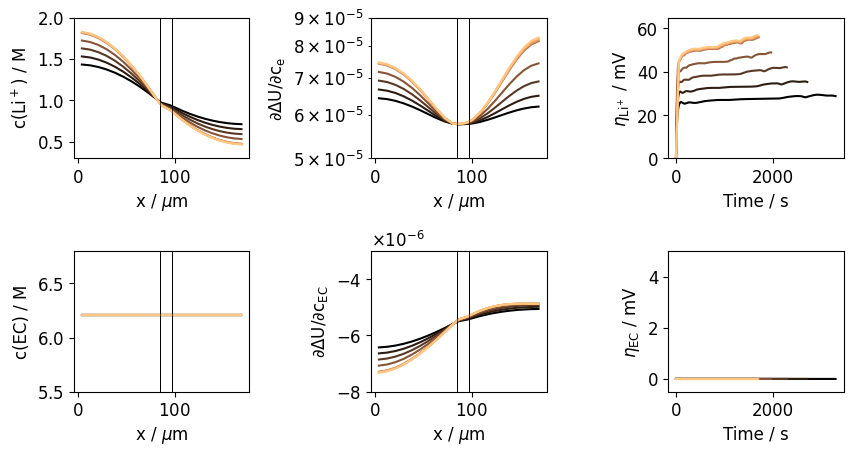

In [89]:
# for sol_high_Dx but different C rate:

fs = 12
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
Str=[ 'DFN',   'Double trans' ]; # Str_model =[ 'Model_DFN',   'Model_DD' ]
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
Labels = ["Single",r"Double-Low $D_\times$",r"Double-High $D_\times$"]
LS = ['-','--','-',];MS=['none','none','h']; ms = 8
Str=[ 'DFN',  'Double' ]

def Plot_Eta_OneSol(Sol_List,Ylim,str,Save_Fig):

    def Plot_One_Crate(Sol_List,Crate_index,cm):
        step = Sol_List['Sol_All'][Crate_index].cycles[0].steps[1]

        axs[0,2].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            -step["X-averaged battery concentration overpotential [V]"].entries*1e3,
            color=cm(Crate_index)) 
        axs[1,2].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            -step["X-averaged battery EC concentration overpotential [V]"].entries*1e3,
            color=cm(Crate_index)) 
    
        #fig.suptitle(f"EC and Li+ overpotential - {Rate_Dis_All[Crate_index]}C Discharge", fontsize=fs+1)
        var_elely = [
            "Electrolyte concentration [mol.m-3]",
            "dLJP_dce",
            "EC concentration [mol.m-3]",
            "dLJP_dcEC",] 
        Title_elely = [
            "c(Li+) [M]",
            "dLJP_dce",
            "c(EC) [M]",
            "dLJP_dcEC",]

        Y_0p = np.arange(-1,100,10)
        Index_MN = [ [0,0],[0,1],[1,0],[1,1]     ]
        for i in range(4):
            m,n = Index_MN[i]
            x_Single_High =   step[x_loc[i]].entries[:,0]
            y_Single_High =   step[var_elely[i]].entries[:,-1]
            if var_elely[i].__contains__("[mol.m-3]"): 
                axs[m,n].plot(x_Single_High*1e6, y_Single_High/1e3, color=cm(Crate_index)) 
                axs[m,n].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
                axs[m,n].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
            else:
                axs[m,n].plot(x_Single_High*1e6, y_Single_High, color=cm(Crate_index)) 
                axs[m,n].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
                axs[m,n].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)

            axs[m,n].set_xlabel(r"x / $\mu$m",   fontdict={'family':'DejaVu Sans','size':fs})
            #axs[m,n].set_title(Title_elely[i]) 
            axs[m,n].ticklabel_format( 
                axis='x', style='sci',
                scilimits=[-1e2,1e2], useOffset=None, 
                useLocale=None, useMathText=True)
            axs[m,n].ticklabel_format( 
                axis='y', style='sci',
                scilimits=[-1e-2,1e-2], useOffset=None, 
                useLocale=None, useMathText=True)
            
    fig, axs = plt.subplots(2,3, figsize=(22/2.53,12/2.54),tight_layout=True) #,
    for i in range(len(Rate_Dis_All)):
        Crate_index = i; 
        cm = mpl.cm.get_cmap("copper", len(Rate_Dis_All))  
        Plot_One_Crate(Sol_List,Crate_index,cm)
    axs[0,2].set_ylabel("$\eta_{\mathrm{Li}^+}$ / mV",fontsize=fs)
    #"$\partial\Delta$U/$\partial$c$_\mathrm{EC}$"
    axs[1,2].set_ylabel("$\eta_{\mathrm{EC}}$ / mV",fontsize=fs)
    axs[1,2].set_xlabel("Time / s",fontsize=fs)
    axs[0,2].set_xlabel("Time / s",fontsize=fs)

    axs[0,0].set_ylabel("c(Li$^+$) / M");
    axs[1,0].set_ylabel("c(EC) / M")
    axs[0,1].set_ylabel("$\partial\Delta$U/$\partial$c$_\mathrm{e}$");  
    axs[1,1].set_ylabel("$\partial\Delta$U/$\partial$c$_\mathrm{EC}$")
    axs[0,1].set_yscale("log")
    #axs[1,1].set_yscale("log")

    axs[0,0].set_ylim(Ylim[0])
    axs[0,1].set_ylim(Ylim[1])
    axs[1,0].set_ylim(Ylim[2])
    axs[1,1].set_ylim(Ylim[3])
    axs[0,2].set_ylim(Ylim[4])
    axs[1,2].set_ylim(Ylim[5])
    fig.subplots_adjust(wspace=0, hspace=0)
    """ axs[1,2].legend(prop={'family':'DejaVu Sans','size':fs-0.5},
    loc='upper right',ncol=1,  bbox_to_anchor=(0.92, 0.7),
    frameon=False,markerscale=0.5,borderpad=0.0,
    handlelength=1.4,columnspacing=1) """
    if Save_Fig == True:
        plt.savefig(BasicPath + Target
                +f"Case_{str} Overpotential and concentration.png", dpi=1000)
        plt.savefig(BasicPath + Target + 
                f"Case_{str} Overpotential and concentration.svg") 

fs = 12;font = {'family' : 'DejaVu Sans','size': fs}
mpl.rc('font', **font)
LS = ['-','--','-',]; 
# for Crate_index=-1 - 4.5C

# for Crate_index=-4 - 4C
#Ylim = [[-0.1,4.5],[0.5e-4,2.0e-2],[3.6,8],[-2.e-5,-0.3e-5]]
# for Crate_index=5 -  3C
# Ylim = [[-0.1,4.5],[0.5e-4,3.0e-4],[3.6,8],[-1.2e-5,-0.3e-5]]
# SD_Crate DD_LDx_Crate,DD_HDx_Crate
Save_Fig = True
""" Ylim = [[0.3,2.0],[0.5e-4,0.9e-4],[5.5,6.8],[-0.8e-5,-0.3e-5],[0,65],[-0.5,5]]
Plot_Eta_OneSol(DD_HDx_Crate,Ylim,"DD_HDx_Crate",Save_Fig) """

Ylim = [[0.3,2.0],[0.5e-4,0.9e-4],[5.5,6.8],[-0.8e-5,-0.3e-5],[0,65],[-0.5,5]]
Plot_Eta_OneSol(DD_LDx_Crate,Ylim,"DD_LDx_Crate",Save_Fig)

Ylim = [[0.3,2.0],[0.5e-4,0.9e-4],[5.5,6.8],[-0.8e-5,-0.3e-5],[0,65],[-0.5,5]]
Plot_Eta_OneSol(SD_Crate,Ylim,"SD_Crate",Save_Fig) 

In [52]:
Rate_Dis_All[0:-3]

[1, 1.2, 1.4, 1.6, 1.8]

1.83 7.033554387701601
1.83 7.0683941912049075
1.83 7.11328089664357


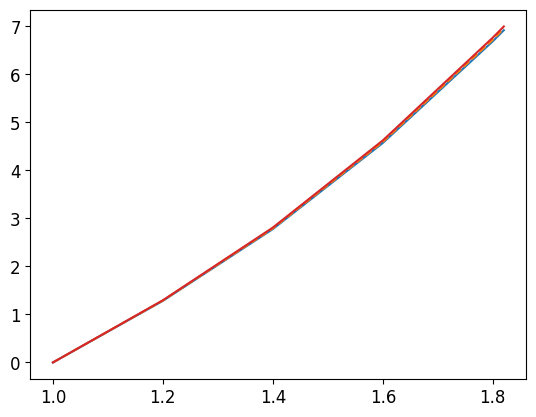

In [67]:
Cases = [SD_Crate,DD_LDx_Crate,DD_HDx_Crate]
for k,case in enumerate(Cases):
    y_temp = case['Cap_Dis_All']; 
    y_plt = (1 - y_temp / y_temp[0])*100
    plt.plot(
        Rate_Dis_All[0:-1],y_plt[0:-1],color=Colors[k],
        linestyle=LS[k],label=Labels[k]) 
    #print(Rate_Dis_All[-3],y_plt[-3])
    print(Rate_Dis_All[-1],y_plt[-1])

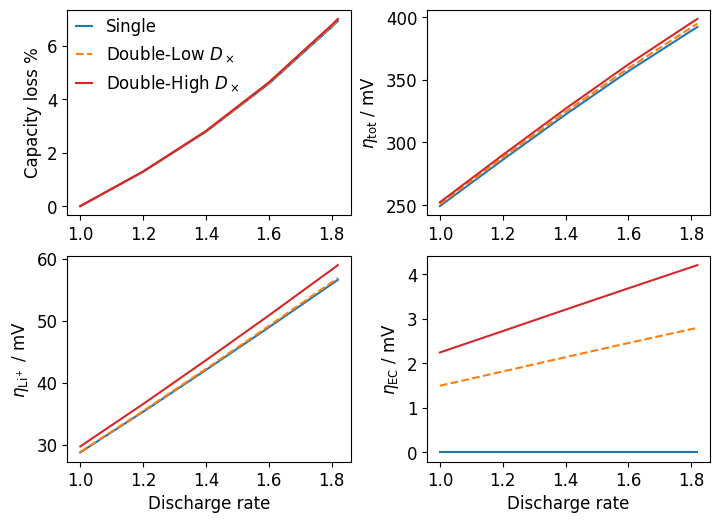

In [93]:
# Fig. 5 - Plot summary and overpotential 
def Plot_Summary_VolCom_Last(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Save_Fig):
    fig, axs = plt.subplots(2,2 , figsize=(18/2.54,13/2.54),layout='constrained') #
    Cases = [SD_Crate,DD_LDx_Crate,DD_HDx_Crate]
    for k,case in enumerate(Cases):
            y_temp = case['Cap_Dis_All'][0:-1]; 
            y_plt = (1 - y_temp / y_temp[0])*100
            axs[0,0].plot(
                Rate_Dis_All[0:-1],y_plt,color=Colors[k],
                linestyle=LS[k],label=Labels[k]) 
            axs[0,1].plot(
                Rate_Dis_All[0:-1],np.array(case['Cyc Last eta_tot'][0:-1])*1e3,
                color=Colors[k],linestyle=LS[k],label=Labels[k]) 
            axs[1,0].plot(
                Rate_Dis_All[0:-1],np.array(case['Cyc Last eta_c_e'][0:-1])*1e3,
                color=Colors[k],linestyle=LS[k],label=Labels[k]) 
            axs[1,1].plot(
                Rate_Dis_All[0:-1],np.array(case['Cyc Last eta_c_EC'][0:-1])*1e3,
                color=Colors[k],linestyle=LS[k],label=Labels[k]) 
    axs[0,0].set_ylabel("Capacity loss %")
    axs[0,1].set_ylabel("$\eta_{\mathrm{tot}}$ / mV",fontsize=fs)
    axs[1,0].set_ylabel("$\eta_{\mathrm{Li^+}}$ / mV",fontsize=fs)
    axs[1,1].set_ylabel("$\eta_{\mathrm{EC}}$ / mV",fontsize=fs)
    for k in range(2):
         axs[1,k].set_xlabel("Discharge rate")
    axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs},
        loc='best',ncol=1,  #bbox_to_anchor=(1, -0.00),
        frameon=False,markerscale=0.5,borderpad=0.0,
        handlelength=1.0,columnspacing=1)
    if Save_Fig == True:
        plt.savefig(BasicPath +  Target+ 
            f"Fig_5_Summary Elely Overpotential last.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"Fig_5_Elely Overpotential last.svg")  
fs = 12
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Str=[ 'DFN',   'Double trans' ]; # Str_model =[ 'Model_DFN',   'Model_DD' ]
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
Labels = ["Single",r"Double-Low $D_\times$",r"Double-High $D_\times$"]
LS = ['-','--','-',];MS=['none','none','h']; ms = 8
Plot_Summary_VolCom_Last(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Save_Fig)

In [55]:
953.1-878.2

74.89999999999998

In [56]:
Cases = [SD_Crate,DD_LDx_Crate,DD_HDx_Crate]
y_plt_all = [];
for i in range(3):
    y_temp = Cases[i]['Cap_Dis_All']; 
    y_plt = (1 - y_temp / y_temp[0])*100
    y_plt_all.append(y_plt)
for i in range(len(Rate_Dis_All)):
    print(
    round(Rate_Dis_All[i],3),round(y_plt_all[0][i],1),
    round(y_plt_all[1][i],1),round(y_plt_all[2][i],1),)
    # case['Cyc Last eta_tot']
    #print(
    #    round(Rate_Dis_All[i],3),
    #    round(Cases[0]['Cyc Last eta_tot'][i],4),
    #    round(Cases[1]['Cyc Last eta_tot'][i],4),
    #    round(Cases[2]['Cyc Last eta_tot'][i],4),)

1 0.0 0.0 0.0
1.2 1.3 1.3 1.3
1.4 2.8 2.8 2.8
1.6 4.6 4.6 4.6
1.8 6.7 6.7 6.8
1.81 6.8 6.8 6.9
1.82 6.9 7.0 7.0
1.83 7.0 7.1 7.1


/tmp/ipykernel_7015/3742633841.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = mpl.cm.get_cmap("cool", len(DD_HDx_Crate['Sol_All']))


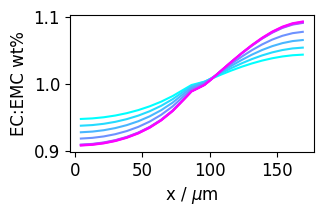

In [91]:
# Plot EC:DMC wt%
cm = mpl.cm.get_cmap("cool", len(DD_HDx_Crate['Sol_All'])) 
def Plot_EC_DMC_Crate(DD_HDx_Crate,Save_Fig):
    Y_0p = np.arange(-1,10,0.1)
    fig, axs = plt.subplots( figsize=(8/2.54,4.5/2.54), ) #tight_layout=True
    for i,sol_Double_High in enumerate(DD_HDx_Crate['Sol_All']):
        step_i  =sol_Double_High.cycles[0].steps[1]
        t_i = (step_i['Time [s]'].entries-step_i['Time [s]'].entries[0]).tolist()
        x_Double_High =   step_i["x [m]"].entries[:,0]
        y_Double_High =   step_i["EC:EMC wt%"].entries[:,-1]
        axs.plot(x_Double_High*1e6, y_Double_High, 
                 color=cm(i),linestyle=LS[0],
                 label=r"Double-High D$_\times$") 

        axs.set_xlabel(r"x / $\mu$m",fontdict={'family':'DejaVu Sans','size':fs})
        #axs.set_title(Title_keys[i]) 
        axs.ticklabel_format( 
            axis='x', style='sci',
            scilimits=[-1e3,1e3], useOffset=None, 
            useLocale=None, useMathText=None)
    axs.set_ylabel("EC:EMC wt%")
    #axs.legend(prop={'family':'DejaVu Sans','size':fs-3},loc='best',frameon=False)  
    #axs[0].set_ylim([-0.1,4.1])
    #axs[1].set_ylim([1.7,4.8])
    #axs[2].set_ylim([5.5,7.6])
    # fig.suptitle(f"3C Discharge, t={round(t_select)} s", fontsize=fs+1)
    if Save_Fig == True:
        plt.savefig(BasicPath +  Target+ f"c.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ f"EC:EMC wt%.svg")  

Plot_EC_DMC_Crate(DD_HDx_Crate,Save_Fig)


In [58]:
cm = mpl.cm.get_cmap("cool", len(DD_HDx_Crate['Sol_All'])) 
i=-1
Labels = ["Single",r"Double-Low $D_\times$",r"Double-High $D_\times$"]
var = [
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "Battery voltage [V]",
    #"c(EMC) [mol.m-3]",
    #"Total electrolyte concentration [mol.m-3]",

    "EC Lithium ion cross diffusivity [m2.s-1]",
    #"EC transference number",
    #"Cation transference number",

    #"Electrolyte conductivity [S.m-1]",
    #"dLJP_dcEC",
    #"dLJP_dce",

    
]
quick_plot = pybamm.QuickPlot(
    [
        SD_Crate['Sol_All'][i].cycles[0].steps[1], 
        DD_LDx_Crate['Sol_All'][i].cycles[0].steps[1], 
        DD_HDx_Crate['Sol_All'][i].cycles[0].steps[1], 
        ], var,Labels,variable_limits='tight',    # 
    time_unit='hours') #figsize = (18,12),
quick_plot.dynamic_plot()

/tmp/ipykernel_7015/2620218837.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = mpl.cm.get_cmap("cool", len(DD_HDx_Crate['Sol_All']))


interactive(children=(FloatSlider(value=0.008705112112681178, description='t', max=0.47317227813498264, min=0.…

In [59]:
cm = mpl.cm.get_cmap("cool", len(DD_HDx_Crate['Sol_All'])) 
i=-1
Labels = [r"Double-Low $D_\times$",r"Double-High $D_\times$"]#"Single",
var = [
    "Battery voltage [V]",
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
quick_plot = pybamm.QuickPlot(
    [
        #SD_Crate['Sol_All'][i].cycles[0].steps[1], 
        DD_LDx_Crate['Sol_All'][i].cycles[0].steps[1], 
        DD_HDx_Crate['Sol_All'][i].cycles[0].steps[1], 
        ], var,Labels,variable_limits='tight',    # 
    time_unit='hours') #figsize = (18,12),
quick_plot.dynamic_plot()

/tmp/ipykernel_7015/2004910909.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = mpl.cm.get_cmap("cool", len(DD_HDx_Crate['Sol_All']))


interactive(children=(FloatSlider(value=0.008705112112681178, description='t', max=0.47268798771631687, min=0.…

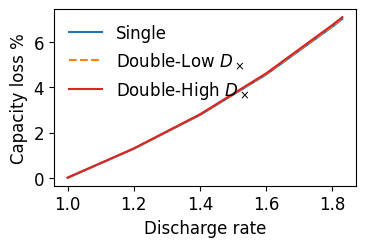

In [60]:
# plot the effect of charge / discharge rate and Dx
fs = 12
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Str=[ 'DFN',   'Double trans' ]; # Str_model =[ 'Model_DFN',   'Model_DD' ]

Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
Labels = ["Single",r"Double-Low $D_\times$",r"Double-High $D_\times$"]
LS = ['-','--','-',];MS=['none','none','h']; ms = 8

def Plot_Summary(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Save_Fig):
        fig, axs = plt.subplots( figsize=(9/2.54,6/2.54), layout='constrained')
        Cases = [SD_Crate,DD_LDx_Crate,DD_HDx_Crate]
        for k,case in enumerate(Cases):
                y_temp = case['Cap_Dis_All']; 
                y_plt = (1 - y_temp / y_temp[0])*100
                axs.plot(
                        Rate_Dis_All,y_plt,color=Colors[k],
                        linestyle=LS[k],label=Labels[k]) 
        axs.set_ylabel("Capacity loss %")
        axs.set_xlabel("Discharge rate")
        axs.set_xlabel("Discharge rate")
        #axs.set_ylim(3.9,5.1);   # axs[1].set_ylim(3.9,5.1)

        #axs[0].set_title(r"$D_\times=1.5\bullet10^{-12}  m^2/s$", fontdict={'family':'DejaVu Sans','size':fs})
        #axs[1].set_title(r"$D_\times=1.5\bullet10^{-10}  m^2/s$", fontdict={'family':'DejaVu Sans','size':fs})
        axs.legend(prop={'family':'DejaVu Sans','size':fs},loc='best',frameon=False,)
        #axs.legend(prop={'family':'DejaVu Sans','size':fs},loc='best',frameon=False,)
        if Save_Fig == True:
                plt.savefig(
                        BasicPath + Target+"Fig_3-Summary Crate.png", dpi=1000)
                plt.savefig(BasicPath + Target + 
                        f'Fig_3-Summary Crate.svg') 
Plot_Summary(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Save_Fig)

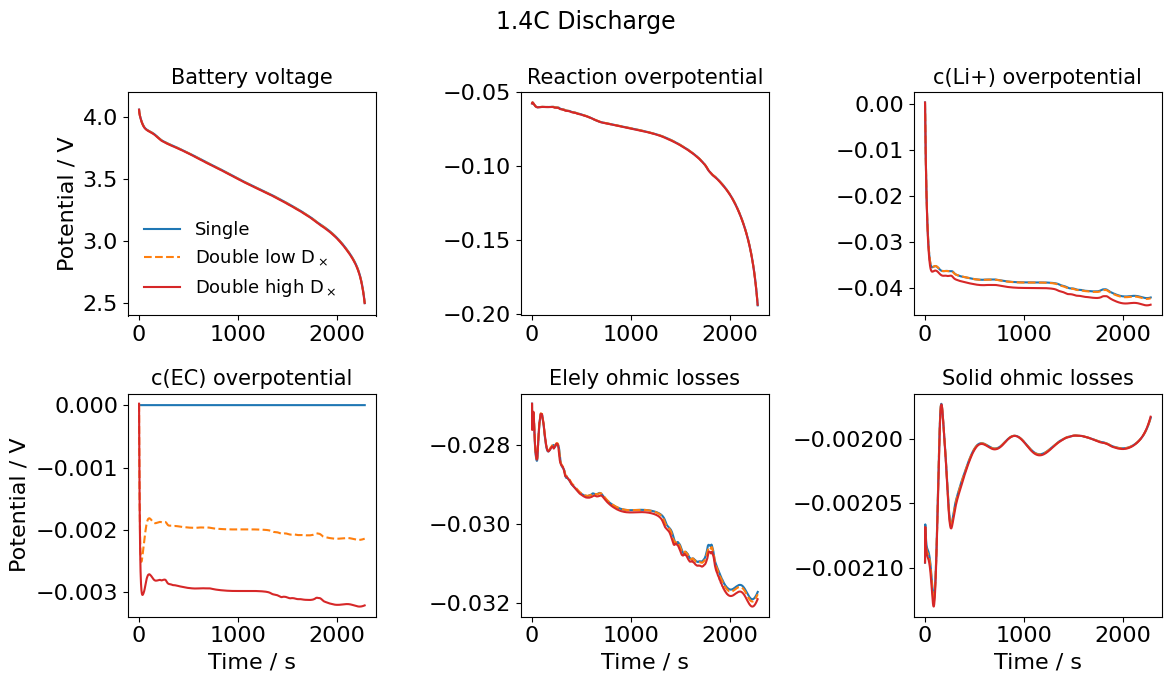

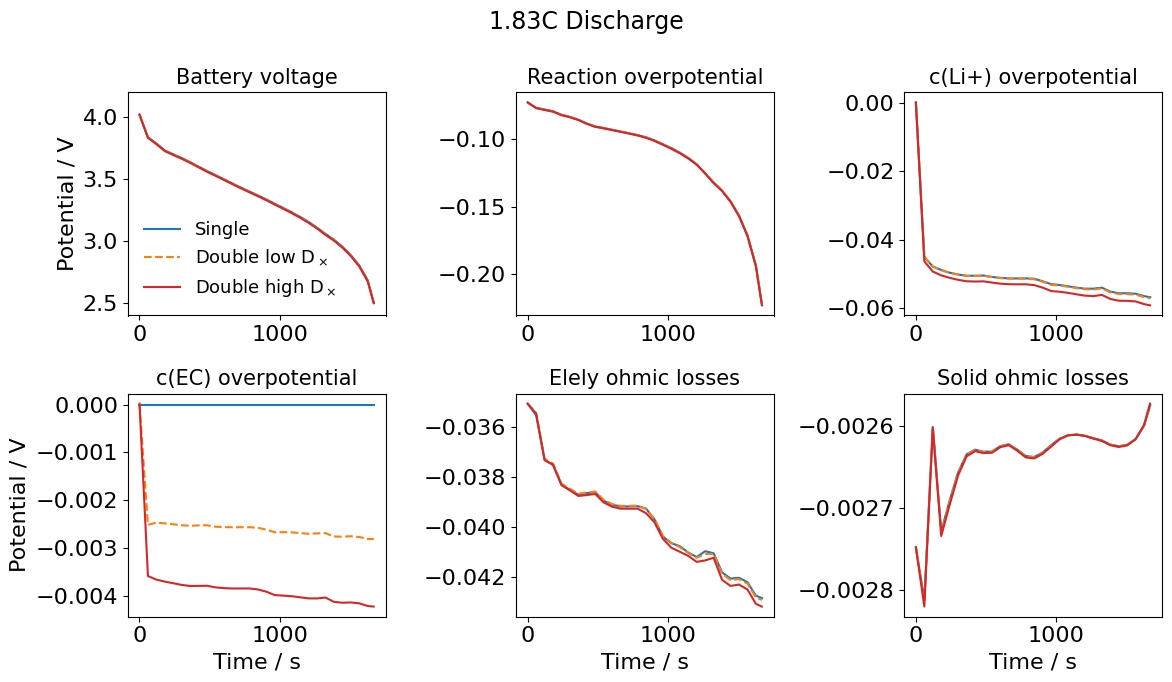

In [94]:
# plot voltage stuff:
fs = 16
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
LS = ['-','--','-',];
def Plot_Voldecom_All(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index,Save_Fig):
    # Crate_index = -1
    sol_sd = SD_Crate['Sol_All'][Crate_index]
    sol_dd_HDx = DD_HDx_Crate['Sol_All'][Crate_index]
    sol_dd_LDx = DD_LDx_Crate['Sol_All'][Crate_index]
    Sol_All = [sol_sd,sol_dd_LDx,sol_dd_HDx,];
    Str = ["Single",r"Double low D$_\times$",r"Double high D$_\times$"]
    fig, axs = plt.subplots(2,3, figsize=(12,7),tight_layout=True)
    Keys_t_var = [
        "Battery voltage [V]",
        "X-averaged battery reaction overpotential [V]",
        "X-averaged battery concentration overpotential [V]",
        "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
        "X-averaged battery electrolyte ohmic losses [V]",
        "X-averaged battery solid phase ohmic losses [V]",
    ]
    Title_keys = [
        "Battery voltage",
        "Reaction overpotential",
        "c(Li+) overpotential",
        "c(EC) overpotential",
        "Elely ohmic losses",
        "Solid ohmic losses"
    ]
    for k,sol in enumerate(Sol_All):
        time_1 = sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0]
        for i in range(0,6): # 0 1 2 3 4 5 --> [0,0] [0,1], [0,2], [1,0], [1,1], [1,2]   
            var =  sol.cycles[0].steps[1][Keys_t_var[i]].entries
            if i < 3:
                m=0; n =i
            else:
                m=1; n=i-3
            axs[m,n].plot(time_1, var,color=Colors[k],linestyle=LS[k],label=Str[k]) # label="1st cycle"
            axs[m,n].set_title(Title_keys[i],fontdict={'family':'DejaVu Sans','size':fs-1})
            
            axs[1,n].set_xlabel('Time / s',   fontdict={'family':'DejaVu Sans','size':fs})
            fig.suptitle(f"{Rate_Dis_All[Crate_index]}C Discharge", fontsize=fs+1)
            
            labels = axs[m,n].get_xticklabels() + axs[m,n].get_yticklabels(); 
            axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-3},loc='best',frameon=False)  
        axs[0,0].set_ylim(2.4,4.2)
    axs[0,0].set_ylabel("Potential / V",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[1,0].set_ylabel("Potential / V",   fontdict={'family':'DejaVu Sans','size':fs})
    if Save_Fig == True:
        plt.savefig(BasicPath + Target
                +f"{Rate_Dis_All[Crate_index]}C Vol decom all.png", dpi=1000)
        plt.savefig(BasicPath + Target + 
                f"{Rate_Dis_All[Crate_index]}C Vol decom all.svg") 
Plot_Voldecom_All(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,2,Save_Fig)
Plot_Voldecom_All(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,-1,Save_Fig)

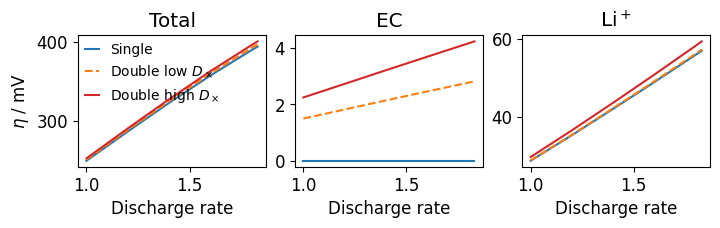

In [96]:
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
LS = ['-','--','-',];MS=['none','none','h']; ms = 8
def Plot_Voldecom_mean_Eley(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Save_Fig):
    fig, axs = plt.subplots(1,3 , figsize=(18/2.54,5.5/2.54),layout='constrained') #
    axs[0].plot(Rate_Dis_All,SD_Crate['Cyc Mean eta_tot'],
                color=Colors[0],linestyle=LS[0],label=r"Single") # marker = MS[1],markerfacecolor='w',markersize = ms,
    axs[1].plot(Rate_Dis_All,SD_Crate['Cyc Mean eta_c_EC'],
                color=Colors[0],linestyle=LS[0],label=r"Single")
    axs[2].plot(Rate_Dis_All,SD_Crate['Cyc Mean eta_c_e'],
                color=Colors[0],linestyle=LS[0],label=r"Single")

    axs[0].plot(Rate_Dis_All,DD_LDx_Crate['Cyc Mean eta_tot'],
                color=Colors[1],linestyle=LS[1], label=r"Double low D$_\times$")
    axs[1].plot(Rate_Dis_All,DD_LDx_Crate['Cyc Mean eta_c_EC'],
        color=Colors[1],linestyle=LS[1],label=r"Double low D$_\times$")
    axs[2].plot(Rate_Dis_All,DD_LDx_Crate['Cyc Mean eta_c_e'],
        color=Colors[1],linestyle=LS[1],label=r"Double low D$_\times$")

    axs[0].plot(Rate_Dis_All,DD_HDx_Crate['Cyc Mean eta_tot'],
                color=Colors[2],linestyle=LS[2], label=r"Double high D$_\times$")
    axs[1].plot(Rate_Dis_All,DD_HDx_Crate['Cyc Mean eta_c_EC'],
        color=Colors[2],linestyle=LS[2],label=r"Double high D$_\times$")
    axs[2].plot(Rate_Dis_All,DD_HDx_Crate['Cyc Mean eta_c_e'],
        color=Colors[2],linestyle=LS[2],label=r"Double high D$_\times$")
    axs[0].set_ylabel("Overpotential / V")
    axs[0].set_xlabel("Discharge rate")
    axs[1].set_xlabel("Discharge rate")
    axs[2].set_xlabel("Discharge rate")
    axs[0].set_title("Total") 
    axs[1].set_title("EC") 
    axs[2].set_title(r"Li$^+$") 
    if Save_Fig == True:
        plt.savefig(BasicPath +  Target+ 
            f"Elely Overpotential mean.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"Elely Overpotential mean.svg")  
def Plot_Voldecom_last_Eley(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Save_Fig):
    fig, axs = plt.subplots(1,3 , figsize=(18/2.54,5.5/2.54),layout='constrained') #
    
    LS = ['-','--','-',];MS=['none','none','h']; ms = 8

    axs[0].plot(Rate_Dis_All,np.array(SD_Crate['Cyc Last eta_tot'])*1e3,
                color=Colors[0],linestyle=LS[0],label=r"Single") # marker = MS[1],markerfacecolor='w',markersize = ms,
    axs[1].plot(Rate_Dis_All,np.array(SD_Crate['Cyc Last eta_c_EC'])*1e3,
                color=Colors[0],linestyle=LS[0],label=r"Single")
    axs[2].plot(Rate_Dis_All,np.array(SD_Crate['Cyc Last eta_c_e'])*1e3,
                color=Colors[0],linestyle=LS[0],label=r"Single")

    axs[0].plot(Rate_Dis_All,np.array(DD_LDx_Crate['Cyc Last eta_tot'])*1e3,
                color=Colors[1],linestyle=LS[1], label=r"Double low $D_\times$")
    axs[1].plot(Rate_Dis_All,np.array(DD_LDx_Crate['Cyc Last eta_c_EC'])*1e3,
        color=Colors[1],linestyle=LS[1],label=r"Double low D$_\times$")
    axs[2].plot(Rate_Dis_All,np.array(DD_LDx_Crate['Cyc Last eta_c_e'])*1e3,
        color=Colors[1],linestyle=LS[1],label=r"Double low D$_\times$")

    axs[0].plot(Rate_Dis_All,np.array(DD_HDx_Crate['Cyc Last eta_tot'])*1e3,
                color=Colors[2],linestyle=LS[2], label=r"Double high $D_\times$")
    axs[1].plot(Rate_Dis_All,np.array(DD_HDx_Crate['Cyc Last eta_c_EC'])*1e3,
        color=Colors[2],linestyle=LS[2],label=r"Double high D$_\times$")
    axs[2].plot(Rate_Dis_All,np.array(DD_HDx_Crate['Cyc Last eta_c_e'])*1e3,
        color=Colors[2],linestyle=LS[2],label=r"Double high D$_\times$")
    axs[0].set_ylabel("$\eta$ / mV")
    axs[0].set_xlabel("Discharge rate")
    axs[1].set_xlabel("Discharge rate")
    axs[2].set_xlabel("Discharge rate")
    axs[0].set_title("Total") 
    axs[1].set_title("EC") 
    axs[2].set_title(r"Li$^+$") 
    axs[0].legend(prop={'family':'DejaVu Sans','size':fs-2},
        loc='best',ncol=1,  #bbox_to_anchor=(1, -0.00),
        frameon=False,markerscale=0.5,borderpad=0.0,
        handlelength=1.0,columnspacing=1)
    if Save_Fig == True:
        plt.savefig(BasicPath +  Target+ 
            f"Elely Overpotential last.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"Elely Overpotential last.svg")  
fs = 12;font = {'family' : 'DejaVu Sans','size': fs}
mpl.rc('font', **font)
Plot_Voldecom_last_Eley(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Save_Fig)
#Plot_Voldecom_mean_Eley(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Save_Fig)

In [63]:
Colors

['#1f77b4', '#ff7f0e', '#d62728']

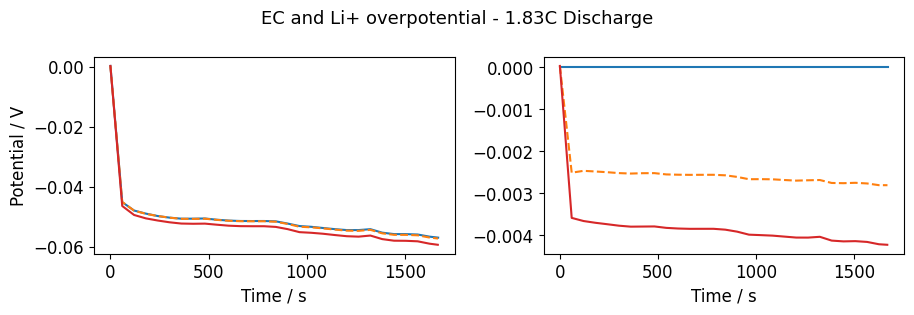

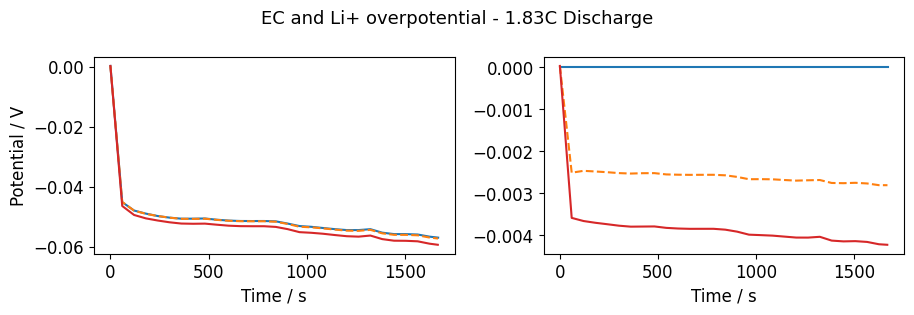

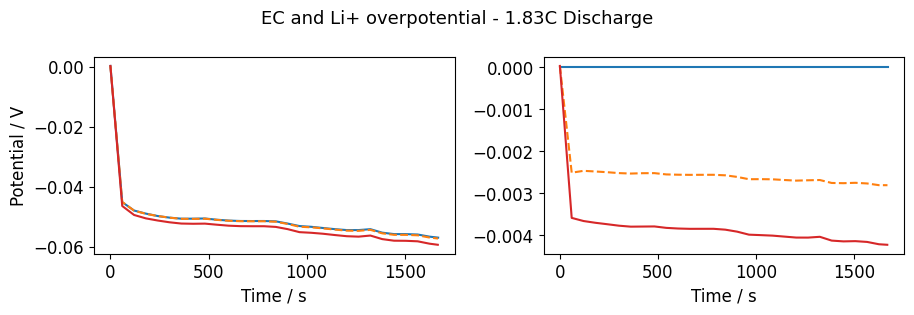

In [64]:
# old version - 3C rate: to plot only c_EC and c_Li+
LS = ['-','--','-','--'];
def Plot_Voldecom_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index,Save_Fig):
    fig, axs = plt.subplots(1,2, figsize=(9.3,3.2),tight_layout=True)
    sol = SD_Crate['Sol_All'][Crate_index]
    axs[0].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged battery concentration overpotential [V]"].entries,
        color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
    axs[1].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged EC concentration overpotential [V]"].entries,
        color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 

    sol = DD_LDx_Crate['Sol_All'][Crate_index]
    axs[0].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged battery concentration overpotential [V]"].entries,
        color=Colors[1],linestyle=LS[1],label=r"Double-Low $D_\times$") 
    axs[1].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged EC concentration overpotential [V]"].entries,
        color=Colors[1],linestyle=LS[1],label=r"Double-Low $D_\times$") 

    sol = DD_HDx_Crate['Sol_All'][Crate_index]
    axs[0].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged battery concentration overpotential [V]"].entries,
        color=Colors[2],linestyle=LS[2],label=r"Double-High $D_\times$") 
    axs[1].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged EC concentration overpotential [V]"].entries,
        color=Colors[2],linestyle=LS[2],label=r"Double-High $D_\times$") 

    axs[0].set_ylabel("Potential / V",fontsize=fs)
    axs[1].set_xlabel("Time / s",fontsize=fs)
    axs[0].set_xlabel("Time / s",fontsize=fs)
    fig.suptitle(f"EC and Li+ overpotential - {Rate_Dis_All[Crate_index]}C Discharge", fontsize=fs+1)
    if Save_Fig == True:
        plt.savefig(BasicPath +  Target+ 
            f"EC and Li+ Overpotential {Rate_Dis_All[Crate_index]}C discharge.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"EC and Li+ Overpotential {Rate_Dis_All[Crate_index]}C discharge.svg")  
Save_Fig = True; Crate_index=-1
Plot_Voldecom_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index,Save_Fig)
Plot_Voldecom_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index,Save_Fig)
Plot_Voldecom_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index,Save_Fig)

Time selected is for 1.83C is 1625.9618601538978 and 1625.9618601538975,1625.9618601538978 s
Time selected is for 1.83C is 1625.9618601538978 and 1625.9618601538975,1625.9618601538978 s
Time selected is for 1.83C is 1625.9618601538978 and 1625.9618601538975,1625.9618601538978 s


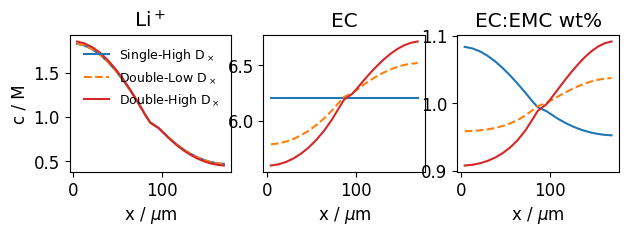

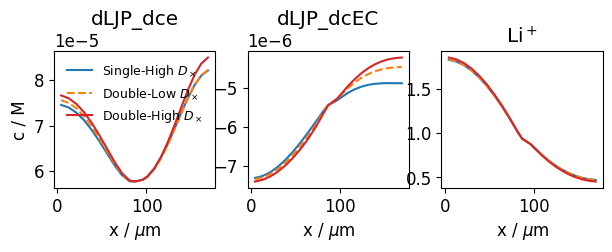

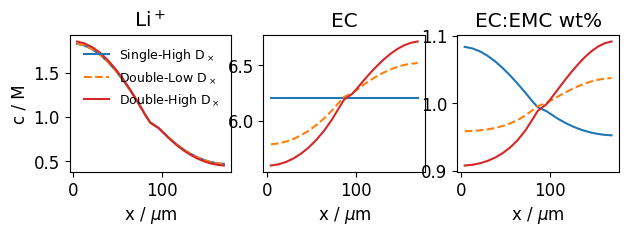

In [65]:
# compare conccnetration
def Plot_Concentration_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_elely,Title_keys,Crate_index,Save_Fig):
    sol_Single_High =  SD_Crate['Sol_All'][Crate_index]
    time_Single_High = (sol_Single_High.cycles[0].steps[1]['Time [s]'].entries-sol_Single_High.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()
    sol_Double_High = DD_HDx_Crate['Sol_All'][Crate_index]
    time_Double_High = (sol_Double_High.cycles[0].steps[1]['Time [s]'].entries-sol_Double_High.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()
    sol_Double_Low = DD_LDx_Crate['Sol_All'][Crate_index]
    time_Double_Low = (sol_Double_Low.cycles[0].steps[1]['Time [s]'].entries-sol_Double_Low.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()

    t_select = min(time_Single_High[-2],time_Double_High[-2],time_Double_Low[-2])
    i_Single_High = FindClose(time_Single_High,t_select)
    i_Double_High = FindClose(time_Double_High,t_select)

    i_Double_Low = FindClose(time_Double_Low,t_select)

    print(f'Time selected is for {Rate_Dis_All[Crate_index]}C is {time_Single_High[i_Single_High]} and {time_Double_High[i_Double_High]},{time_Double_Low[i_Double_Low]} s')
    Y_0p = np.arange(-1,10,0.1)
    fig, axs = plt.subplots(1,3, figsize=(18/2.54,4.5/2.54), ) #tight_layout=True
    for i in range(3):
        x_Single_High =   sol_Single_High.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Single_High =   sol_Single_High.cycles[0].steps[1][var_elely[i]].entries[:,i_Single_High]

        x_Double_High =   sol_Double_High.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Double_High =   sol_Double_High.cycles[0].steps[1][var_elely[i]].entries[:,i_Double_High]
        x_Double_Low =   sol_Double_Low.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Double_Low =   sol_Double_Low.cycles[0].steps[1][var_elely[i]].entries[:,i_Double_Low]
        if var_elely[i].__contains__("[mol.m-3]"): 
            axs[i].plot(x_Single_High*1e6, y_Single_High/1e3, color=Colors[0],linestyle=LS[0],label=r"Single-High D$_\times$") 
            axs[i].plot(x_Double_Low*1e6, y_Double_Low/1e3, color=Colors[1],linestyle=LS[1],label=r"Double-Low D$_\times$") 
            axs[i].plot(x_Double_High*1e6, y_Double_High/1e3, color=Colors[2],linestyle=LS[0],label=r"Double-High D$_\times$") 
            #axs[i].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
            #axs[i].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
        else:
            axs[i].plot(x_Single_High*1e6, y_Single_High, color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
            axs[i].plot(x_Double_Low*1e6, y_Double_Low, color=Colors[1],linestyle=LS[1],label=r"Double-Low $D_\times$") 
            axs[i].plot(x_Double_High*1e6, y_Double_High, color=Colors[2],linestyle=LS[0],label=r"Double-High $D_\times$") 

        axs[i].set_xlabel(r"x / $\mu$m",   fontdict={'family':'DejaVu Sans','size':fs})
        axs[i].set_title(Title_keys[i]) 
        axs[i].ticklabel_format( 
            axis='x', style='sci',
            scilimits=[-1e3,1e3], useOffset=None, 
            useLocale=None, useMathText=None)
    axs[0].set_ylabel("c / M")
    axs[0].legend(prop={'family':'DejaVu Sans','size':fs-3},loc='best',frameon=False)  
    #axs[0].set_ylim([-0.1,4.1])
    #axs[1].set_ylim([1.7,4.8])
    #axs[2].set_ylim([5.5,7.6])
    # fig.suptitle(f"3C Discharge, t={round(t_select)} s", fontsize=fs+1)
    if Save_Fig == True:
        plt.savefig(BasicPath +  Target+ 
            f"{Rate_Dis_All[Crate_index]}C Discharge, t={round(t_select)} s concentration profile.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"{Rate_Dis_All[Crate_index]}C Discharge, t={round(t_select)} s concentration profile.svg")  
x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
var_elely = [
    "Electrolyte concentration [mol.m-3]",
    "EC concentration [mol.m-3]",
    "EC:EMC wt%",]  # "c(EMC) [mol.m-3]",] 
var_LJP = [
    "dLJP_dce",
    "dLJP_dcEC",
    "Electrolyte concentration [mol.m-3]",] 
Title_LJP = [
    "dLJP_dce",
    "dLJP_dcEC",
    r"Li$^+$",]
Title_keys = [
    r"Li$^+$",
    "EC",
    "EC:EMC wt%",]
Save_Fig = True; Crate_index = -1
Plot_Concentration_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_elely,Title_keys,Crate_index,Save_Fig)
Plot_Concentration_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_LJP,Title_LJP,Crate_index,Save_Fig)
Plot_Concentration_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_elely,Title_keys,Crate_index,Save_Fig)

Time selected is for 1C is 3285.999999999999 and 3285.9999999999995,3286.0 s
Time selected is for 1.8C is 1702.5999999999992 and 1702.5999999999995,1702.5999999999995 s
Time selected is for 1.83C is 1625.9618601538978 and 1625.9618601538975,1625.9618601538978 s


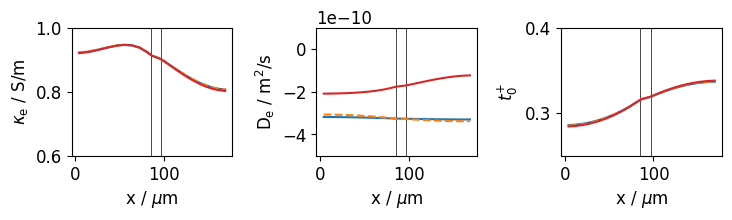

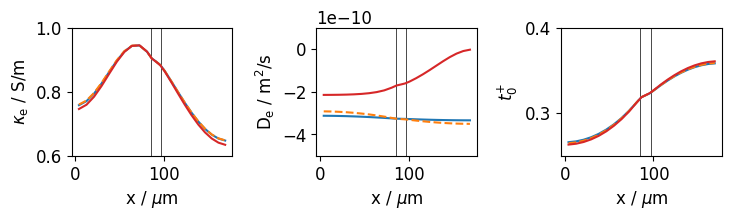

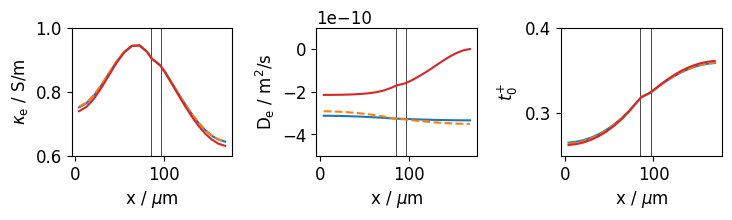

In [104]:
# compare electrolyte properties
def Plot_EleyPro_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_elely,Title_keys,Crate_index,Ylim,Save_Fig):

    sol_Single_High =  SD_Crate['Sol_All'][Crate_index]
    time_Single_High = (sol_Single_High.cycles[0].steps[1]['Time [s]'].entries-sol_Single_High.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()
    sol_Double_High = DD_HDx_Crate['Sol_All'][Crate_index]
    time_Double_High = (sol_Double_High.cycles[0].steps[1]['Time [s]'].entries-sol_Double_High.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()
    sol_Double_Low = DD_LDx_Crate['Sol_All'][Crate_index]
    time_Double_Low = (sol_Double_Low.cycles[0].steps[1]['Time [s]'].entries-sol_Double_Low.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()

    t_select = min(time_Single_High[-2],time_Double_High[-2],time_Double_Low[-2])
    i_Single_High = FindClose(time_Single_High,t_select)
    i_Double_High = FindClose(time_Double_High,t_select)

    i_Double_Low = FindClose(time_Double_Low,t_select)

    print(f'Time selected is for {Rate_Dis_All[Crate_index]}C is {time_Single_High[i_Single_High]} and {time_Double_High[i_Double_High]},{time_Double_Low[i_Double_Low]} s')
    
    Y_0p = np.arange(-1e-8,3,1e-1)
    fig, axs = plt.subplots(1,3, figsize=(19/2.54,6/2.54),tight_layout=True) # 
    for i in range(3):
        x_Single_High =   sol_Single_High.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Single_High =   sol_Single_High.cycles[0].steps[1][var_elely[i]].entries[:,i_Single_High]

        x_Double_High =   sol_Double_High.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Double_High =   sol_Double_High.cycles[0].steps[1][var_elely[i]].entries[:,i_Double_High]
        x_Double_Low =   sol_Double_Low.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Double_Low =   sol_Double_Low.cycles[0].steps[1][var_elely[i]].entries[:,i_Double_Low]
        axs[i].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
        axs[i].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
        axs[i].plot(x_Single_High*1e6, y_Single_High, color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
        axs[i].plot(x_Double_Low*1e6, y_Double_Low, color=Colors[1],linestyle=LS[1],label=r"Double-Low $D_\times$") 
        axs[i].plot(x_Double_High*1e6, y_Double_High, color=Colors[2],linestyle=LS[0],label=r"Double-High $D_\times$") 
        axs[i].set_xlabel(r"x / $\mu$m",   fontdict={'family':'DejaVu Sans','size':fs})
        #axs[i].set_title(Title_keys[i]) 
        axs[i].ticklabel_format( 
            axis='x', style='sci',
            scilimits=[-1e3,1e3], useOffset=None, 
            useLocale=None, useMathText=None)
        axs[i].set_ylim(Ylim[i])
    axs[0].set_ylabel("$\kappa_\mathrm{e}$ / S/m")
    axs[1].set_ylabel("D$_\mathrm{e}$ / m$^\mathrm{2}$/s") # 
    axs[2].set_ylabel("$\mathit{t}_\mathrm{0}^\mathrm{+}$")
    """ axs[2].legend(prop={'family':'DejaVu Sans','size':fs-2},
    loc='best',ncol=1,  #bbox_to_anchor=(1, -0.00),
    frameon=False,markerscale=0.5,borderpad=0.0,
    handlelength=1.0,columnspacing=1) """
    if Save_Fig == True:
        plt.savefig(BasicPath +  Target+ 
            f"Fig_S2_{Rate_Dis_All[Crate_index]}C Discharge, t={round(t_select)} s electrolyte properties.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"Fig_S2_{Rate_Dis_All[Crate_index]}C Discharge, t={round(t_select)} s electrolyte properties.svg") 
x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
var_elely = [
    "Electrolyte conductivity [S.m-1]",
    "EC Lithium ion cross diffusivity [m2.s-1]",
    "Cation transference number",]
Title_keys = [
    r"Li$^+$",
    "EC",
    "EMC",]
fs = 12
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Ylim = [ [0.6,1.0] ,  [-5e-10,1e-10] , [0.25,0.4] ] 
for i in [0,4,-1]:
    Plot_EleyPro_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
        x_loc,var_elely,Title_keys,Crate_index=i,Ylim=Ylim,Save_Fig=True)
